In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/1qAFBTNjNxFrK3-A6i9WwUFfWhekcINRO/view?usp=drive_link"
direct_link = get_direct_link(link)
df = pd.read_csv(direct_link)

In [3]:
df = df.sort_values(by='Date')

split_index = int(0.75 * len(df))

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

test_df.reset_index(drop=True, inplace=True)

print('Fit set rows: '+str(len(train_df)))
print('Test set rows: '+str(len(test_df)))

Fit set rows: 26800
Test set rows: 8934


In [4]:
train_df.Date = pd.to_datetime(train_df.Date, format='%Y-%m-%d')
train_df = train_df.sort_values(by='Date')

test_df.Date = pd.to_datetime(test_df.Date, format='%Y-%m-%d')
test_df = test_df.sort_values(by='Date')

In [5]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(rank=True, wiki=True):
    features = ['inverse_avg']
    if rank:
        features.append('rankdist')
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, rankdist=None, wikibuzz=None):
    prob = coef[0] + coef[1] * inv_odds  
    if rankdist is not None:
        prob += coef[2] * rankdist
    if wikibuzz is not None:
        prob += coef[-1] * wikibuzz
    return prob

def kelly(implied_prob, predicted_prob):
    return max(predicted_prob - ((1 - predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else -stake

def estimate_probabilities(test_data, coef, odds_provider, use_rank=True, use_wiki=True):
    if use_rank and use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], row['rankdist'], row['wikibuzz']), axis=1)
    elif use_rank:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], rankdist=row['rankdist']), axis=1)
    elif use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], wikibuzz=row['wikibuzz']), axis=1)
    else:
        test_data['est_prob'] = test_data['inverse_avg'].apply(lambda x: model_prob(coef, x))

    return test_data

def display_results(test_data, odds_provider):
    bet_considered = len(test_data[test_data[f'inverse_{odds_provider}'].notna()])
    bets_placed = len(test_data.loc[(test_data["correct_profit"].notna()) & (test_data["correct_profit"] != 0)])
    mean_overround = ((test_data.sort_values(by="match_id")[f"inverse_{odds_provider}"].rolling(2).sum().iloc[1::2].mean() - 1) * 100)
    total_stake = test_data['correct_stake'].sum()
    total_return = test_data['correct_profit'].sum()
    roi = (((total_return + total_stake) / total_stake) - 1) * 100
    
    results = {
        'Bets considered (2 * Matches)': bet_considered,
        'Number of bets placed': bets_placed,
        'Mean overround (%)': mean_overround,
        'Absolute amount bet': total_stake,
        'Absolute return': total_return,
        'ROI (%)': roi
    }
    
    return results

def show_results(test_data, coef, odds_provider, rank=True, wiki=True):
    test_data = estimate_probabilities(test_data, coef, odds_provider, rank, wiki)
    test_data['stake'] = [kelly(a, b) for a, b in zip(test_data[f'inverse_{odds_provider}'], test_data['est_prob'])]
    test_data['profit'] = [profit(a, b, c) for a, b, c in zip(test_data['stake'], test_data[f'inverse_{odds_provider}'], test_data['outcome'])]
    
    test_df['original_stake'] = [kelly(a,b) for a,b in zip(test_df['inverse_{}'.format(odds_provider)], test_df['est_prob'])]
    test_df['original_profit'] = [profit(a,b,c) for a,b,c in zip(test_df['original_stake'],test_df['inverse_{}'.format(odds_provider)],test_df['outcome'])]
    test_df['post-bet_balance'] = (test_df['original_profit'] + 1).cumprod()
    test_df['pre-bet_balance'] = test_df['post-bet_balance'].shift(1)
    test_df['correct_stake'] = test_df['original_stake'] * test_df['pre-bet_balance']
    test_df['correct_profit'] = test_df['original_profit'] * test_df['pre-bet_balance']
    
    results = display_results(test_data, odds_provider)
    print(results)
    return results

def plot_results(test_df):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('Date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)

    ax.set_title('Cumulative Profit Over Time', fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)

    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

def plot_results_save(test_df, filename, title):
    test_df['cum_profit'] = test_df['correct_profit'].cumsum()
    fig, ax = plt.subplots(figsize=(10, 6))
    test_df.plot('Date', 'cum_profit', ax=ax, color='blue', linewidth=2.0)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_ylabel('Absolute Return', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    ax.tick_params(axis='both', labelsize=12)

    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()


In [6]:
# preferred model on B365
coef = train_model()

In [7]:
coef

array([-0.00152231,  0.95109766,  0.01863947, -0.03246122])

{'Bets considered (2 * Matches)': 8934, 'Number of bets placed': 2699, 'Mean overround (%)': 5.294503817445473, 'Absolute amount bet': 612136569.6317673, 'Absolute return': 5406.553194917738, 'ROI (%)': 0.0008832266299885205}


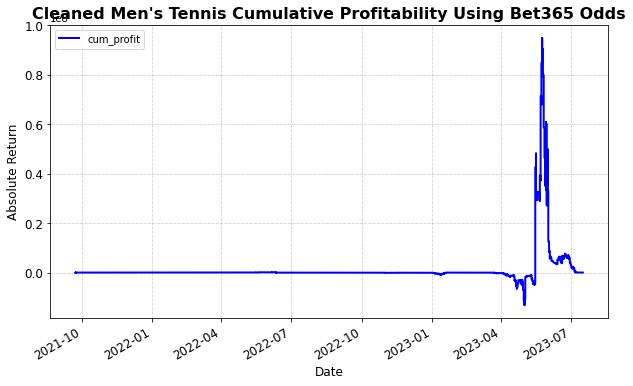

In [8]:
show_results(test_df, coef, 'B365')
plot_results_save(test_df, 'mens_tennis_clean1.png', "Cleaned Men's Tennis Cumulative Profitability Using Bet365 Odds")

{'Bets considered (2 * Matches)': 8934, 'Number of bets placed': 2685, 'Mean overround (%)': 5.294503817445473, 'Absolute amount bet': -369574168.05942726, 'Absolute return': -3344.421028777957, 'ROI (%)': 0.0009049390671256319}


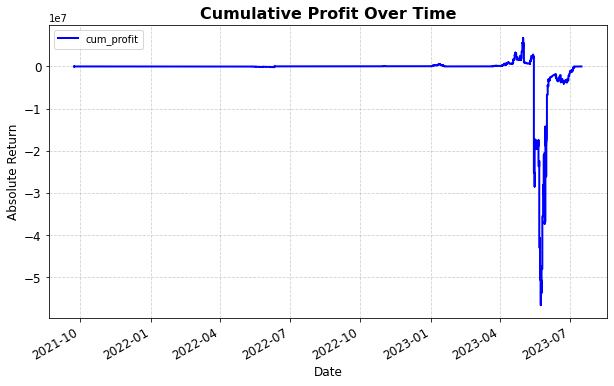

In [9]:
# PM w/o rank on B365
coef = train_model(rank=False)
show_results(test_df, coef, 'B365', rank = False)
plot_results(test_df)